Este bloque importa las librerías esenciales: `os` para manejar archivos y directorios, `numpy` para operaciones matemáticas, `matplotlib.pyplot` para gráficos, y ImageDataGenerator de Keras para preprocesar y aumentar imágenes en el modelo.

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Este bloque establece Google Drive en Colab, define las rutas para las carpetas de entrenamiento y test, y verifica que dichos directorios existan en el sistema.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

base_dir  = "/content/drive/MyDrive/P3IA/Numbers"
train_dir = base_dir + "/Train"
test_dir  = base_dir + "/Test"

print("train_dir:", train_dir)
print("test_dir :", test_dir)

import os
print("¿Existe train_dir?:", os.path.isdir(train_dir))
print("¿Existe test_dir?:", os.path.isdir(test_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_dir: /content/drive/MyDrive/P3IA/Numbers/Train
test_dir : /content/drive/MyDrive/P3IA/Numbers/Test
¿Existe train_dir?: True
¿Existe test_dir?: True


Este bloque establece las dimensiones de las imágenes y el tamaño del batch para el modelo. También crea los generadores de datos para el conjunto de entrenamiento y test, aplicando el reescalado de las imágenes y reservando un 20% de los datos de entrenamiento para la validación.

In [24]:
IMG_HEIGHT = 280
IMG_WIDTH  = 280
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

Este bloque configura los generadores de datos para entrenamiento, validación y test. Se asegura de que las imágenes se reescale a las dimensiones necesarias (280x280 en este caso) y que estén en escala de grises. Además, asigna los directorios correspondientes y organiza los conjuntos de datos en entrenamiento, validación y test, asegurando que el entrenamiento y validación se barajen, pero no el test.

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # TODAS se reescalan a 28x28
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 5685 images belonging to 10 classes.
Found 1415 images belonging to 10 classes.
Found 2064 images belonging to 10 classes.


Este bloque de código obtiene un lote de imágenes y etiquetas del generador train_generator. Se imprime la forma de las imágenes `(batch_x.shape)` y los valores mínimo y máximo de las imágenes dentro del lote. Esto muestra cómo se han normalizado las imágenes a un rango de [0, 1].

Luego, el código visualiza las primeras 6 imágenes del lote, usando matplotlib para mostrar las imágenes en escala de grises. La clase de cada imagen (el dígito que representa) se muestra como título en cada subgráfico, utilizando `np.argmax(batch_y[i])`, que obtiene la etiqueta de la clase asociada a cada imagen. Finalmente, se eliminan los ejes de cada imagen con `plt.axis("off")` para una visualización más limpia.

Shape batch_x: (8, 280, 280, 1)
Mínimo: 0.0 Máximo: 1.0


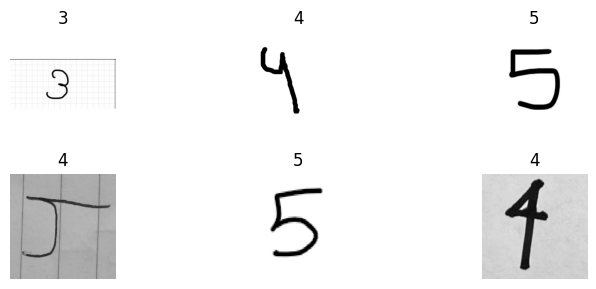

In [26]:
batch_x, batch_y = next(train_generator)
print("Shape batch_x:", batch_x.shape)
print("Mínimo:", batch_x.min(), "Máximo:", batch_x.max())

plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(batch_x[i].squeeze(), cmap="gray")
    plt.title(np.argmax(batch_y[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

Este bloque obtiene el número de clases del generador de datos de entrenamiento `train_generator` usando `train_generator.num_classes`, que indica cuántas categorías diferentes tiene el modelo que clasificar (en este caso, 10 clases para los dígitos del 0 al 9).

También se define la forma de entrada del modelo, que debe coincidir con las dimensiones de las imágenes que alimentamos al modelo: en este caso, `(IMG_HEIGHT, IMG_WIDTH, 1)`, donde 1 indica que las imágenes son en escala de grises.

In [27]:

num_classes = train_generator.num_classes
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

print("Número de clases:", num_classes)
print("Input shape:", input_shape)

Número de clases: 10
Input shape: (280, 280, 1)


Este código construye un modelo convolucional básico con 3 bloques convolucionales `(Conv2D + MaxPooling2D)` seguidos de una capa densa `(Dense)`. La red usa relu como función de activación en las capas convolucionales y densas, con softmax en la capa de salida para clasificación multiclase. El modelo es compilado con el optimizador Adam y categorical crossentropy como la función de pérdida.

El modelo es entrenado con el generador train_generator, utilizando 7 épocas `(epochs = 7)`, y un EarlyStopping para evitar el sobreajuste, interrumpiendo el entrenamiento si la pérdida de validación no mejora después de 5 épocas.

In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
num_classes = train_generator.num_classes

def build_baseline_model():
    model = Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Capa densa
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


baseline_model = build_baseline_model()
baseline_model.summary()


epochs = 7

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_baseline = baseline_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,490 (76.92 MB)

 Trainable params: 20,164,490 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 1492s 2s/step - accuracy: 0.3371 - loss: 2.0149 - val_accuracy: 0.7307 - val_loss: 1.0584
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.7855 - loss: 0.7263 - val_accuracy: 0.7555 - val_loss: 0.9907
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.8593 - loss: 0.4582 - val_accuracy: 0.7710 - val_loss: 1.0622
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.8989 - loss: 0.3238 - val_accuracy: 0.7633 - val_loss: 1.0560
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 69s 97ms/step - accuracy: 0.9139 - loss: 0.2653 - val_accuracy: 0.7802 - val_loss: 1.2879
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.9388 - loss: 0.1821 - val_accuracy: 0.7731 - val_loss: 1.6316
Epoch 7/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.9454 - loss: 0.1706 - val_accuracy: 0.7887 - val_loss: 1.7538


Este es el **Modelo 2**, que es una red convolucional más sencilla con solo 2 bloques convolucionales. Se utilizan menos filtros en las capas convolucionales `(16 y 32)`, y una capa densa con 64 neuronas. Además, se incorpora un Dropout de 50% para regularizar el modelo. El modelo es compilado con el optimizador Adam y la función de pérdida categorical crossentropy. El entrenamiento se realiza en 7 épocas con early stopping para evitar el sobreajuste.

In [29]:
# MODELO 2: CNN más sencilla (menos filtros, 2 bloques conv)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model_2():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = train_generator.num_classes

    model = Sequential([
        # Bloque 1
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_2 = build_model_2()
model_2.summary()

epochs_2 = 7
early_stop_2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_2 = model_2.fit(
    train_generator,
    epochs=epochs_2,
    validation_data=val_generator,
    callbacks=[early_stop_2],
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 280, 280, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 140, 140, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 140, 140, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 70, 70, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,040,714 (38.30 MB)

 Trainable params: 10,040,714 (38.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 76s 100ms/step - accuracy: 0.1908 - loss: 2.4614 - val_accuracy: 0.5795 - val_loss: 1.4989
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.4833 - loss: 1.4675 - val_accuracy: 0.6537 - val_loss: 1.1959
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - accuracy: 0.6571 - loss: 1.0372 - val_accuracy: 0.6664 - val_loss: 1.1345
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - accuracy: 0.7356 - loss: 0.7691 - val_accuracy: 0.7074 - val_loss: 1.0463
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.8059 - loss: 0.5671 - val_accuracy: 0.7152 - val_loss: 1.0864
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.8209 - loss: 0.5228 - val_accuracy: 0.7025 - val_loss: 1.1731
Epoch 7/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - accuracy: 0.8444 - loss: 0.4308 - val_accuracy: 0.7258 - val_loss: 1.2132


Este es el **Modelo 3**, que es una red convolucional más profunda con 4 bloques convolucionales. Aumenta la cantidad de filtros progresivamente `(32, 64, 128, 256)` y agrega un Dropout de 50% para evitar el sobreajuste. La capa densa final tiene 256 neuronas. El modelo se compila con el optimizador Adam y la función de pérdida categorical crossentropy. El entrenamiento se realiza en 7 épocas con early stopping para evitar el sobreajuste.

In [30]:
# MODELO 3: CNN más profunda (4 bloques conv, más filtros)

from tensorflow.keras.layers import BatchNormalization

def build_model_3():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = train_generator.num_classes

    model = Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 4 extra
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_3 = build_model_3()
model_3.summary()

epochs_3 = 7
early_stop_3 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_3 = model_3.fit(
    train_generator,
    epochs=epochs_3,
    validation_data=val_generator,
    callbacks=[early_stop_3],
    verbose=1
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 35, 35, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    18,940,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,330,570 (73.74 MB)

 Trainable params: 19,330,570 (73.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 78s 103ms/step - accuracy: 0.3289 - loss: 1.9065 - val_accuracy: 0.7562 - val_loss: 0.9167
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.7999 - loss: 0.6370 - val_accuracy: 0.7816 - val_loss: 0.8224
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.8966 - loss: 0.3319 - val_accuracy: 0.8219 - val_loss: 0.7436
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 69s 97ms/step - accuracy: 0.9439 - loss: 0.1817 - val_accuracy: 0.8099 - val_loss: 0.8840
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.9442 - loss: 0.1711 - val_accuracy: 0.8240 - val_loss: 1.0822
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.9646 - loss: 0.1158 - val_accuracy: 0.8226 - val_loss: 0.9716
Epoch 7/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - accuracy: 0.9721 - loss: 0.0896 - val_accuracy: 0.8184 - val_loss: 1.0556


Este es el **Modelo 4**, que utiliza Batch Normalization para mejorar la convergencia durante el entrenamiento. La red consta de 3 bloques convolucionales con BatchNormalization seguido de cada capa convolucional. El modelo utiliza ReLU como función de activación después de cada BatchNormalization y tiene un Dropout de 50% para evitar sobreajuste. Se compila con el optimizador Adam y la función de pérdida categorical crossentropy. El modelo se entrena durante 7 épocas con early stopping para evitar sobreajuste.

In [31]:
# MODELO 4: CNN con Batch Normalization

def build_model_4():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = train_generator.num_classes

    model = Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        # activación después de BN
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_4 = build_model_4()
model_4.summary()

epochs_4 = 7
early_stop_4 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_4 = model_4.fit(
    train_generator,
    epochs=epochs_4,
    validation_data=val_generator,
    callbacks=[early_stop_4],
    verbose=1
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 280, 280, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 280, 280, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 140, 140, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 140, 140, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 70, 70, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 70, 70, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,359,146 (77.66 MB)

 Trainable params: 20,358,698 (77.66 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 92s 114ms/step - accuracy: 0.1021 - loss: 7.8972 - val_accuracy: 0.1011 - val_loss: 2.3025
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - accuracy: 0.1059 - loss: 2.3026 - val_accuracy: 0.1018 - val_loss: 2.3559
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - accuracy: 0.0954 - loss: 2.3028 - val_accuracy: 0.1018 - val_loss: 2.3524
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 72s 101ms/step - accuracy: 0.0943 - loss: 2.3027 - val_accuracy: 0.1018 - val_loss: 2.3612
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 69s 97ms/step - accuracy: 0.0991 - loss: 2.3031 - val_accuracy: 0.1018 - val_loss: 2.3697
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - accuracy: 0.1065 - loss: 2.3027 - val_accuracy: 0.1011 - val_loss: 2.3565


Este es el **Modelo 5**, que utiliza filtros 5x5 en las capas convolucionales. Esta arquitectura aumenta el tamaño del filtro comparado con los modelos anteriores `(usando filtros 3x3)`, lo que permite capturar características más grandes en la imagen. La red tiene tres bloques convolucionales, cada uno seguido de MaxPooling para reducir las dimensiones espaciales. El modelo también incluye Dropout del 50% para evitar sobreajuste y se compila con el optimizador Adam y categorical crossentropy como la función de pérdida. El entrenamiento se realiza durante 7 épocas con early stopping.

In [32]:
# MODELO 5: CNN con filtros 5x5

def build_model_5():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = train_generator.num_classes

    model = Sequential([
        # Bloque 1
        Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_5 = build_model_5()
model_5.summary()

epochs_5 = 7
early_stop_5 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_5 = model_5.fit(
    train_generator,
    epochs=epochs_5,
    validation_data=val_generator,
    callbacks=[early_stop_5],
    verbose=1
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 280, 280, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 140, 140, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 70, 70, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,328,842 (77.55 MB)

 Trainable params: 20,328,842 (77.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.3165 - loss: 2.0212 - val_accuracy: 0.7187 - val_loss: 1.0491
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.7715 - loss: 0.7127 - val_accuracy: 0.7696 - val_loss: 0.9687
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.8804 - loss: 0.3953 - val_accuracy: 0.7739 - val_loss: 0.9180
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 69s 97ms/step - accuracy: 0.9193 - loss: 0.2616 - val_accuracy: 0.7548 - val_loss: 1.3480
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.9410 - loss: 0.1908 - val_accuracy: 0.7887 - val_loss: 1.1743
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.9528 - loss: 0.1494 - val_accuracy: 0.7908 - val_loss: 1.3961
Epoch 7/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.9567 - loss: 0.1458 - val_accuracy: 0.7901 - val_loss: 1.4552


Este es el **Modelo 6**, que usa GlobalAveragePooling2D en lugar de Flatten para reducir las dimensiones antes de pasar a la capa densa. Esta técnica ayuda a reducir el número de parámetros del modelo, lo que lo hace más eficiente. El modelo tiene 3 bloques convolucionales seguidos de una capa de GlobalAveragePooling2D, lo que reduce la representación espacial a un solo valor promedio por filtro. Después, pasa a una capa densa con 64 neuronas y se aplica Dropout del 50% para evitar el sobreajuste. El modelo se compila con el optimizador Adam y la función de pérdida categorical crossentropy. El entrenamiento se realiza durante 7 épocas con early stopping.

In [34]:
# MODELO 6: CNN con GlobalAveragePooling2D en lugar de Flatten

from tensorflow.keras.layers import GlobalAveragePooling2D

def build_model_6():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = train_generator.num_classes

    model = Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloque 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloque 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # En vez de Flatten -> GlobalAveragePooling2D
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model_6 = build_model_6()
model_6.summary()

epochs_6 = 7
early_stop_6 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_6 = model_6.fit(
    train_generator,
    epochs=epochs_6,
    validation_data=val_generator,
    callbacks=[early_stop_6],
    verbose=1
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,578 (396.79 KB)

 Trainable params: 101,578 (396.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.1117 - loss: 2.3021 - val_accuracy: 0.1371 - val_loss: 2.2909
Epoch 2/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.1561 - loss: 2.2494 - val_accuracy: 0.2127 - val_loss: 2.1131
Epoch 3/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.2303 - loss: 2.0021 - val_accuracy: 0.3095 - val_loss: 1.9443
Epoch 4/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.3368 - loss: 1.7679 - val_accuracy: 0.3477 - val_loss: 1.9305
Epoch 5/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 63s 89ms/step - accuracy: 0.3841 - loss: 1.6703 - val_accuracy: 0.3555 - val_loss: 1.9884
Epoch 6/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - accuracy: 0.4178 - loss: 1.6111 - val_accuracy: 0.4311 - val_loss: 1.7575
Epoch 7/7
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.4318 - loss: 1.5271 - val_accuracy: 0.4191 - val_loss: 1.7367


Este bloque compara los modelos entrenados en términos de exactitud de validación `(val_accuracy)`. Para cada modelo, se obtiene la mejor exactitud de validación y la época en la que ocurrió. Luego, todos los modelos se ordenan en un DataFrame por su `best_val_accuracy`. Finalmente, el modelo con la mejor exactitud de validación se selecciona y se muestra, junto con la época en la que alcanzó su mejor rendimiento.

In [35]:
# Comparar accuracy de todos los modelos y escoger el mejor

import numpy as np
import pandas as pd

histories = {
    "baseline": history_baseline,
    "model_2": history_2,
    "model_3": history_3,
    "model_4": history_4,
    "model_5": history_5,
    "model_6": history_6,
}

models = {
    "baseline": baseline_model,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_4,
    "model_5": model_5,
    "model_6": model_6,
}

rows = []
for name, hist in histories.items():
    val_acc_list = hist.history.get("val_accuracy", [])
    acc_list = hist.history.get("accuracy", [])

    if len(val_acc_list) == 0:
        best_val_acc = np.nan
        best_epoch = None
    else:
        best_val_acc = float(np.max(val_acc_list))
        best_epoch = int(np.argmax(val_acc_list)) + 1  # épocas comienzan en 1

    last_train_acc = float(acc_list[-1]) if len(acc_list) > 0 else np.nan

    rows.append({
        "model": name,
        "best_val_accuracy": best_val_acc,
        "epoch_best_val": best_epoch,
        "last_train_accuracy": last_train_acc,
    })

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values("best_val_accuracy", ascending=False)

print("Comparación de modelos (ordenados del mejor al peor por val_accuracy):")
display(results_df)

best_row = results_df.iloc[0]
best_model_name = best_row["model"]
best_model = models[best_model_name]

print(f"\nMejor modelo según val_accuracy: {best_model_name}")
print(f"Mejor val_accuracy: {best_row['best_val_accuracy']:.4f} en la época {int(best_row['epoch_best_val'])}")


Comparación de modelos (ordenados del mejor al peor por val_accuracy):


,model,best_val_accuracy,epoch_best_val,last_train_accuracy
2,model_3,0.824028,5,0.970273
4,model_5,0.790813,6,0.954266
0,baseline,0.788693,7,0.943360
1,model_2,0.725795,7,0.847669
5,model_6,0.431095,6,0.443096
3,model_4,0.101767,2,0.097801



Mejor modelo según val_accuracy: model_3
Mejor val_accuracy: 0.8240 en la época 5


Este código genera dos gráficas para el modelo ganador seleccionado previamente:

*  Gráfica de Exactitud `(Accuracy)`: Compara la exactitud de entrenamiento y validación a través de las épocas, usando train_acc y val_acc.
*  Gráfica de Pérdida `(Loss)`: Compara la pérdida de entrenamiento y validación a través de las épocas, usando train_loss y val_loss.

Cada gráfica muestra cómo evoluciona el rendimiento del modelo durante el entrenamiento, lo que ayuda a identificar problemas como sobreajuste `(overfitting)` o falta de convergencia.

Mejor modelo (usado para el punto 4): model_3


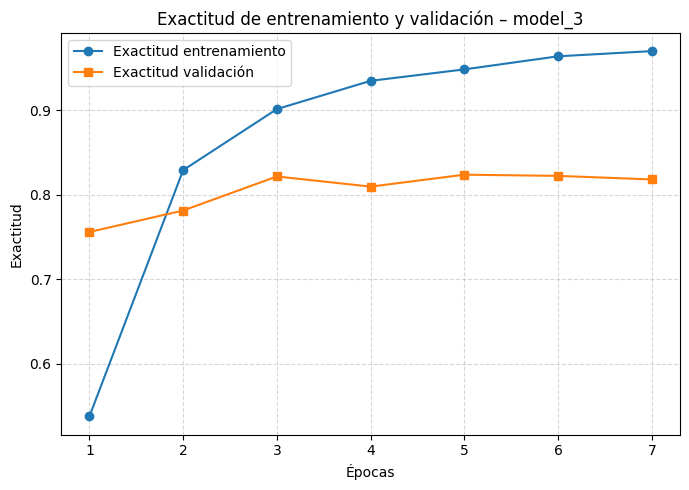

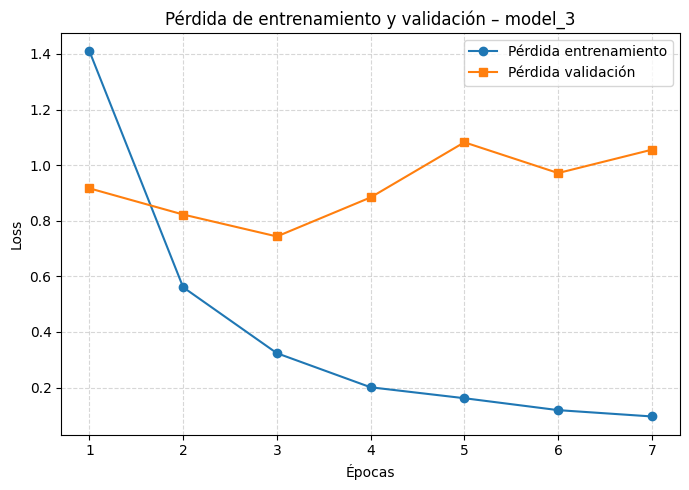

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

histories = {
    "baseline": history_baseline,
    "model_2": history_2,
    "model_3": history_3,
    "model_4": history_4,
    "model_5": history_5,
    "model_6": history_6,
}

print("Mejor modelo (usado para el punto 4):", best_model_name)

best_history = histories[best_model_name]

train_acc = best_history.history["accuracy"]
val_acc   = best_history.history["val_accuracy"]
train_loss = best_history.history["loss"]
val_loss   = best_history.history["val_loss"]

epochs = range(1, len(train_acc) + 1)

# --- Gráfica 1: accuracy entrenamiento vs validación ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_acc, marker='o', label="Exactitud entrenamiento")
plt.plot(epochs, val_acc, marker='s', label="Exactitud validación")
plt.xlabel("Épocas")
plt.ylabel("Exactitud")
plt.title(f"Exactitud de entrenamiento y validación – {best_model_name}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Gráfica 2: loss entrenamiento vs validación ---
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_loss, marker='o', label="Pérdida entrenamiento")
plt.plot(epochs, val_loss, marker='s', label="Pérdida validación")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title(f"Pérdida de entrenamiento y validación – {best_model_name}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Este bloque configura un generador de imágenes `(final_train_generator)` para cargar y preprocesar las imágenes de entrenamiento. Se aplica un reescalado para que los valores de los píxeles estén en el rango de [0, 1] y las imágenes se redimensionan a las dimensiones necesarias `(IMG_HEIGHT, IMG_WIDTH)`. Las imágenes se cargan en escala de grises (como se usó en el modelo) y se procesan en batches con un tamaño definido por BATCH_SIZE. Las imágenes se barajan al cargar para mejorar la generalización del modelo.

In [38]:
final_train_datagen = ImageDataGenerator(rescale=1.0/255.0)

final_train_generator = final_train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 7100 images belonging to 10 classes.


Este es el modelo ganador `(model_3)`, reconstruido para usar todo el conjunto de entrenamiento. La red sigue una estructura convolucional con 4 bloques de Conv2D seguidos de MaxPooling2D, donde el número de filtros aumenta progresivamente de 32 a 256 para capturar características cada vez más complejas. La última capa de salida tiene softmax para realizar clasificación multiclase `(10 clases en este caso)`. El modelo es compilado con el optimizador Adam y la función de pérdida categorical crossentropy.

In [39]:
# MODELO GANADOR (model_3) RECONSTRUIDO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_final_model_3():
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
    num_classes = final_train_generator.num_classes

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

final_model = build_final_model_3()
final_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 280, 280, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 140, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 140, 140, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 70, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 70, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 35, 35, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    18,940,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,330,570 (73.74 MB)

 Trainable params: 19,330,570 (73.74 MB)

 Non-trainable params: 0 (0.00 B)

Este bloque configura el entrenamiento del modelo final. Se usa early stopping para evitar el sobreajuste: el entrenamiento se detendrá si la pérdida en el conjunto de entrenamiento no mejora después de 3 épocas `(patience=3)`. El parámetro restore_best_weights=True asegura que, en caso de que el modelo se detenga temprano, se restauren los pesos del modelo en la mejor época. El entrenamiento se realiza por 12 épocas.

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

epochs_final = 12

early_stop_final = EarlyStopping(
    monitor="loss",
    patience=3,
    restore_best_weights=True
)

history_final = final_model.fit(
    final_train_generator,
    epochs=epochs_final,
    callbacks=[early_stop_final],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.3784 - loss: 1.7685
Epoch 2/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.8378 - loss: 0.5406
Epoch 3/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.9088 - loss: 0.2854
Epoch 4/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9410 - loss: 0.1933
Epoch 5/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.9527 - loss: 0.1507
Epoch 6/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.9573 - loss: 0.1367
Epoch 7/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.9657 - loss: 0.1079
Epoch 8/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9729 - loss: 0.0923
Epoch 9/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 67s 76ms/step - accuracy: 0.9749 - loss: 0.0828
Epoch 10/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9760 - loss: 0.0747
Epoch 11/12
888/888 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9761 - loss: 0.0689
Epoch 12/12
888/888 ━━━━━━━━━━

Este bloque de código realiza la predicción sobre el conjunto de test usando el modelo entrenado `(final_model)`. Primero, obtiene las probabilidades de cada clase `(pred_probs)` y luego las convierte en etiquetas de clase usando np.argmax, seleccionando la clase con la mayor probabilidad. A continuación, se compara con las etiquetas reales del conjunto de test `(true_labels)` y se genera un informe de clasificación utilizando classification_report de sklearn. Este informe muestra métricas como precision, recall, f1-score, etc., para cada clase.

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Obtiene predicciones
pred_probs = final_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Labels reales
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Reporte completo
print(classification_report(true_labels, pred_labels, target_names=class_names))


258/258 ━━━━━━━━━━━━━━━━━━━━ 759s 3s/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       204
           1       0.84      0.90      0.87       211
           2       0.92      0.93      0.92       209
           3       0.93      0.91      0.92       207
           4       0.89      0.89      0.89       207
           5       0.95      0.93      0.94       204
           6       0.92      0.93      0.93       208
           7       0.95      0.92      0.94       207
           8       0.90      0.90      0.90       205
           9       0.94      0.91      0.92       202

    accuracy                           0.91      2064
   macro avg       0.91      0.91      0.91      2064
weighted avg       0.91      0.91      0.91      2064



1.  **Exactitud General:**
El modelo alcanzó una exactitud general de 91%, lo que indica un buen rendimiento general, considerando que está clasificado en 10 clases (dígitos 0–9). Esto significa que el modelo tiene una buena capacidad de generalización.

2.   **Precision y Recall:**
En términos generales, la precisión (precision) y el recall (sensibilidad) se mantienen alrededor del 90% para la mayoría de las clases, lo que muestra que el modelo tiene un buen balance entre precisión y capacidad de detectar correctamente todas las instancias de cada clase. Las clases con la mayor precisión fueron clases 8 y 9 (0.94 para ambas), lo que indica que el modelo es muy preciso al identificar estos dígitos, cometiendo pocos errores de predicción.

3.   **F1-Score:**
El f1-score muestra una tendencia similar, destacando que las clases con los mayores f1-scores son las clases 8 y 9, seguidas de cerca por las clases 2, 3 y 7. Esto sugiere que el modelo tiene un buen rendimiento en la clasificación de estos números, donde combina bien la precisión y el recall.

4.   **Clases con el mayor margen de error:**
La clase 1 (dígito '1') tiene el valor más bajo tanto en precisión (0.84) como en recall (0.90), lo que significa que, aunque el modelo tiene una buena tasa de detección para esta clase, comete más errores al identificarla correctamente. La precisión baja de la clase 1 también puede indicar que el modelo tiene dificultades con ciertas variaciones del '1' en diferentes escrituras, lo que podría ser un área a mejorar en el futuro.

5.   **Métricas de Promedio:**
El macro promedio y el promedio ponderado de la precisión, el recall y el f1-score están en el rango de 0.91, lo que refuerza la idea de que el modelo tiene un rendimiento bastante consistente a través de todas las clases.

6.   **Áreas de mejora:**
Aunque el modelo tiene un buen desempeño general, se podría trabajar en mejorar la clasificación de ciertos dígitos, especialmente el '1'. Investigaciones sobre data augmentation o técnicas de regularización podrían ayudar a que el modelo identifique mejor las variaciones de ciertos números.

In [42]:
from tensorflow.keras.models import save_model

# Guardar en la carpeta actual de Colab
final_model.save("ModeloFinal.h5")
print("Modelo guardado como ModeloFinal.h5")

# Opcional: guardar también en Drive
final_model.save("/content/drive/MyDrive/P3IA/cnn_digits_model.h5")
print("Modelo guardado también en Drive: /content/drive/MyDrive/P3IA/ModeloFinalD.h5")

Modelo guardado como ModeloFinal.h5
Modelo guardado también en Drive: /content/drive/MyDrive/P3IA/ModeloFinalD.h5


Este bloque de código guarda el modelo entrenado final_model en dos ubicaciones:

*   En la carpeta local de Colab, como ModeloFinal.h5. Esto te permitirá descargar el archivo más tarde desde el panel de archivos de Colab.

*   En Google Drive, en la ruta especificada (/content/drive/MyDrive/P3IA/cnn_digits_model.h5). Esto garantiza que el modelo esté almacenado de forma persistente en tu cuenta de Google Drive para acceso futuro.